### Import Libraries

In [2]:
import os
import glob

import cv2
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torchmetrics.classification import Dice

from utilities import AITEX


c:\compute\envs\fdd\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\compute\envs\fdd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [3]:
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")

### Load Data and Model

In [4]:
class AITEXPatched(AITEX):
    def __init__(self, *args, normal_only=False, defect_only=False, **kwargs,):
        super(AITEXPatched, self).__init__(*args, **kwargs)

        self.patched_images = []
        self.patched_masks = []
        self.has_defect = []
        for index, img in enumerate(self.images):
            img_new = 2 * (cv2.resize(img, (4096, 256)) / 255.) - 1 
            self.patched_images.extend([img_new[:,i:i+256] for i in range(0, 4096, 256)])

            mask_new = cv2.resize(self.masks[index], (4096, 256))
            mask_patches = [mask_new[:,i:i+256] for i in range(0, 4096, 256)]
            self.patched_masks.extend(mask_patches)

            self.has_defect.extend([1 if np.sum(x) > 0 else 0 for x in mask_patches])
        
        if normal_only:
            indices = [x for x, y in enumerate(self.has_defect) if y==0]
            self.patched_images = [self.patched_images[x] for x in indices]
            self.patched_masks = [self.patched_masks[x] for x in indices]
            self.has_defect = [self.has_defect[x] for x in indices]
        if defect_only:
            indices = [x for x, y in enumerate(self.has_defect) if y!=0]
            self.patched_images = [self.patched_images[x] for x in indices]
            self.patched_masks = [self.patched_masks[x] for x in indices]
            self.has_defect = [self.has_defect[x] for x in indices]
    
    def __len__(self):
        """Get length of full dataset."""
        return len(self.patched_images)    
    
    def __getitem__(self, idx):
        """Return specific index of dataset."""
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return torch.Tensor(self.patched_images[idx]).reshape((1, 256, 256)), torch.Tensor(self.patched_masks[idx]).reshape((1, 256, 256))

In [5]:
data = AITEXPatched(aitex_dir, defect_only=True)

# images_zero, masks_zero, classes_zero, paths_zero = data.get_by_type(0)
# paths_zero = [x.split('\\')[-1] for x in paths_zero]
# num_images = len(images_zero)

### Train

#### Try to do this with the Focal Tversky Loss

In [9]:
import torch.nn as nn


class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()
        self.smooth = 1.0
        self.alpha = 0.9

    def forward(self, y_true, y_pred):
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        tp = (y_true_flat * y_pred_flat).sum()
        fn = (y_true_flat * (1 - y_pred_flat)).sum()
        fp = ((1 - y_true_flat) * y_pred_flat).sum()
        
        return 1 - (tp + self.smooth) / (tp + self.alpha * fn + (1 - self.alpha) * fp + self.smooth)

In [10]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False)

model.cuda()

Using cache found in C:\Users\Jad Raad/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [14]:
device = "cuda"
dice = TverskyLoss()
optimizer = Adam(model.parameters(), lr=1e-2)
new_shape = (1, 1, 256, 256)

model.train()

for epoch in range(0, 20):
    loss_train = []
    for i, (img, mask) in enumerate(data):
        x = img.reshape(new_shape).to(device)
        y = mask.reshape(new_shape).to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = dice(y, y_pred)

        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch, "Loss:", np.mean(loss_train))

Epoch: 0 Loss: 0.7177531277811205
Epoch: 1 Loss: 0.7148645897169371
Epoch: 2 Loss: 0.5757577512715314
Epoch: 3 Loss: 0.6327328959026852
Epoch: 4 Loss: 0.541793075445536
Epoch: 5 Loss: 0.5411881462947742
Epoch: 6 Loss: 0.5219507500932024
Epoch: 7 Loss: 0.465502269847973
Epoch: 8 Loss: 0.45215272871223655
Epoch: 9 Loss: 0.42541601625648706
Epoch: 10 Loss: 0.43052376830900035
Epoch: 11 Loss: 0.44892351369600036
Epoch: 12 Loss: 0.4233226627916903
Epoch: 13 Loss: 0.39814288745055326
Epoch: 14 Loss: 0.3788106125754279
Epoch: 15 Loss: 0.37757249845040813
Epoch: 16 Loss: 0.3787799542014663
Epoch: 17 Loss: 0.35589134854239385
Epoch: 18 Loss: 0.35645634548084154
Epoch: 19 Loss: 0.33914624517028397


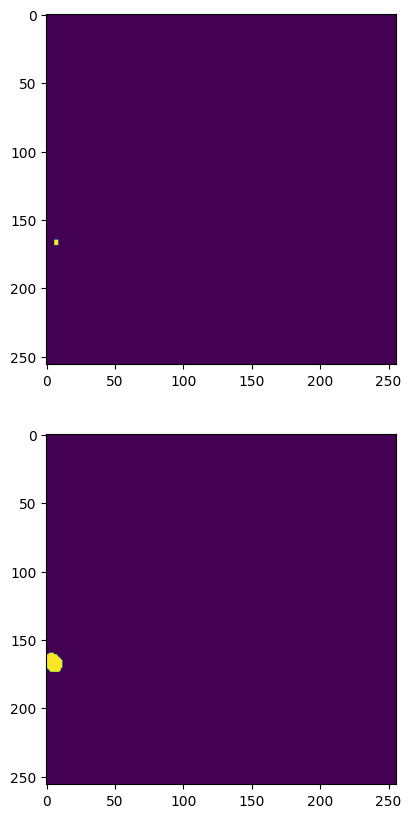

In [15]:
fig, ax = plt.subplots(2, figsize=(10,10))

ax[0].imshow(y.cpu().detach().numpy().reshape((256, 256)))
ax[1].imshow(y_pred.cpu().detach().numpy().reshape((256, 256)))